In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import math
import torch.nn.functional as F

In [3]:
class LorentzDataset(Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples
        self.data = self.generate_dataset()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

    def lorentz_transform(self, x, y, z, t, v):
        gamma = 1 / torch.sqrt(1 - v**2)
        x_prime = gamma * (x - v * t)
        y_prime = y
        z_prime = z
        t_prime = gamma * (t - v * x)
        return torch.tensor([x_prime, y_prime, z_prime, t_prime])

    def generate_dataset(self):
        dataset = []
        v = torch.rand(1) * 0.9  # Random velocity v < 0.9 (since c = 1)

        for _ in range(self.num_samples):
            x = torch.tensor([torch.rand(1) * 20 - 10 for _ in range(4)])  # Random x, y, z, t in range (-10, 10)
            x_prime = self.lorentz_transform(x[0], x[1], x[2], x[3], v)
            dataset.append((x, x_prime))
        return dataset

#num_samples = 1000
dataset = LorentzDataset(num_samples)

print("Example data point:")
print("Input (x, y, z, t):", dataset[0][0])
print("Output (x', y', z', t'):", dataset[0][1])

Example data point:
Input (x, y, z, t): tensor([6.8352, 4.2438, 7.7704, 9.8731])
Output (x', y', z', t'): tensor([1.8408, 4.2438, 7.7704, 7.3584])


In [17]:
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 10% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print("Training data:")
print("Input (x, y, z, t):", train_dataset[0][0])
print("Output (x', y', z', t'):", train_dataset[0][1])

print("\nValidation data:")
print("Input (x, y, z, t):", val_dataset[0][0])
print("Output (x', y', z', t'):", val_dataset[0][1])

print("\nTest data:")
print("Input (x, y, z, t):", test_dataset[0][0])
print("Output (x', y', z', t'):", test_dataset[0][1])


train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Training data:
Input (x, y, z, t): tensor([ 7.8629, -7.8956,  1.7678,  1.5834])
Output (x', y', z', t'): tensor([ 8.3031, -7.8956,  1.7678, -3.1023])

Validation data:
Input (x, y, z, t): tensor([-1.7301, -3.4133, -0.1228,  9.4659])
Output (x', y', z', t'): tensor([-8.0379, -3.4133, -0.1228, 12.2971])

Test data:
Input (x, y, z, t): tensor([-6.8096,  3.5156, -1.8073,  5.3779])
Output (x', y', z', t'): tensor([-11.4622,   3.5156,  -1.8073,  10.6739])


In [11]:
class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, bias=True, ln=False):
        super(MAB, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V, bias=bias)
        self.fc_k = nn.Linear(dim_K, dim_V, bias=bias)
        self.fc_v = nn.Linear(dim_K, dim_V, bias=bias)
        if ln:
            self.ln0 = nn.LayerNorm(dim_V)
            self.ln1 = nn.LayerNorm(dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V, bias=bias)

    def forward(self, Q, K):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)

        A = torch.softmax(Q.bmm(K.transpose(1, 2)) / math.sqrt(self.dim_V), 2)
        O = torch.cat((Q + A.bmm(V)).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        return O, A

class SAB(nn.Module):
    def __init__(self, dim_in=1, dim_out=1, num_heads=1, ln=False, bias=True):
        super(SAB, self).__init__()
        self.mab = MAB(dim_in, dim_in, dim_out, num_heads, ln=ln, bias=bias)

    def forward(self, X):
        return self.mab(X, X)

class SetTransformer(nn.Module):
    def __init__(self, dim_input=1, dim_output=1, num_heads=1, ln=False, bias=True):
        super(SetTransformer, self).__init__()
        self.enc = SAB(dim_input, dim_output, num_heads, ln=ln, bias=bias)

    def forward(self, X):
        return self.enc(X)

# Example usage
model = SetTransformer()

# Example input for a batch with 4 instances, each with 4 elements
X = torch.randn(256, 4, 1)  # [batch_size, seq_len, dim_input]

# Forward pass
output, attn_weights = model(X)
print(output.shape)  # Expected output shape: [4, 4, 4]
print(attn_weights.shape)  # Expected attn_weights shape: [4, 4, 4]



torch.Size([256, 4, 1])
torch.Size([256, 4, 4])


In [13]:
from torch import optim
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# play with lr scheudler

In [22]:
# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

num_epochs = 1000
clip_value = 1.0  # Adjust as needed

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(-1)
        targets = targets.unsqueeze(-1)
        outputs, att = model(inputs.float())  # Assuming model returns both outputs and attention weights
        loss = criterion(outputs, targets.float())
        loss.backward()

        # Perform gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()
        running_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.unsqueeze(-1)
            targets = targets.unsqueeze(-1)
            outputs, _ = model(inputs.float())  # Assuming model returns both outputs and attention weights
            val_loss += criterion(outputs, targets.float()).item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print the losses for the epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

print('Training finished.')



Epoch [1/1000], Train Loss: 1.9603, Val Loss: 1.9102
Epoch [2/1000], Train Loss: 1.9952, Val Loss: 1.9053
Epoch [3/1000], Train Loss: 1.9515, Val Loss: 1.9003
Epoch [4/1000], Train Loss: 1.9530, Val Loss: 1.8954
Epoch [5/1000], Train Loss: 1.9224, Val Loss: 1.8901
Epoch [6/1000], Train Loss: 1.9413, Val Loss: 1.8854
Epoch [7/1000], Train Loss: 1.9801, Val Loss: 1.8812
Epoch [8/1000], Train Loss: 1.9150, Val Loss: 1.8769
Epoch [9/1000], Train Loss: 1.9684, Val Loss: 1.8730
Epoch [10/1000], Train Loss: 1.8729, Val Loss: 1.8682
Epoch [11/1000], Train Loss: 1.8552, Val Loss: 1.8628
Epoch [12/1000], Train Loss: 1.9047, Val Loss: 1.8585
Epoch [13/1000], Train Loss: 1.8678, Val Loss: 1.8544
Epoch [14/1000], Train Loss: 1.9273, Val Loss: 1.8504
Epoch [15/1000], Train Loss: 1.9144, Val Loss: 1.8460
Epoch [16/1000], Train Loss: 1.9220, Val Loss: 1.8412
Epoch [17/1000], Train Loss: 1.8813, Val Loss: 1.8361
Epoch [18/1000], Train Loss: 1.9382, Val Loss: 1.8312
Epoch [19/1000], Train Loss: 1.9014, 

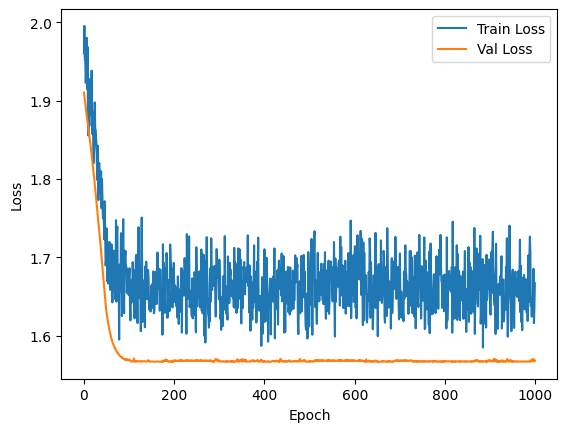

In [23]:
def inference(model, data_loader):
    model.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs, attn_weights = model(inputs)
            # Process outputs or store attention weights as needed
            print("Attention Weights:")
            print(attn_weights)


# After training, you can plot the training and validation losses if needed
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
for batch in test_loader:
  inputs, targets = batch
  inputs = inputs.unsqueeze(-1)
  targets = targets.unsqueeze(-1)

  outputs, att = model(inputs.float())

  break


In [ ]:
outputs

tensor([[-6.8512e+00, -1.8204e-01,  7.1400e+00,  7.8677e-02],
        [ 1.7761e+00,  2.8848e-01,  4.9359e+00,  2.6014e+00],
        [ 8.6337e+00,  3.4884e-01,  1.7914e+00, -3.4663e+00],
        ...,
        [ 3.1515e+00,  2.9770e-01,  1.6399e+00,  3.8571e+00],
        [-7.0847e+00, -4.1658e-01, -4.7413e-01, -2.9209e+00],
        [-1.6111e+00, -6.2442e-03, -1.4588e+00,  3.8595e+00]],
       grad_fn=<AddmmBackward0>)

In [ ]:
targets

tensor([[-9.9755, -7.3561,  8.2854,  4.5241],
        [ 0.9607, -5.4607,  5.0730,  1.2955],
        [ 9.9987,  2.9095,  1.2004, -1.4284],
        ...,
        [ 2.6508,  4.5833, -1.2961,  9.1047],
        [-5.6239, -3.5318,  1.1155, -5.1648],
        [-1.5587,  3.0567,  0.3675,  7.9881]])

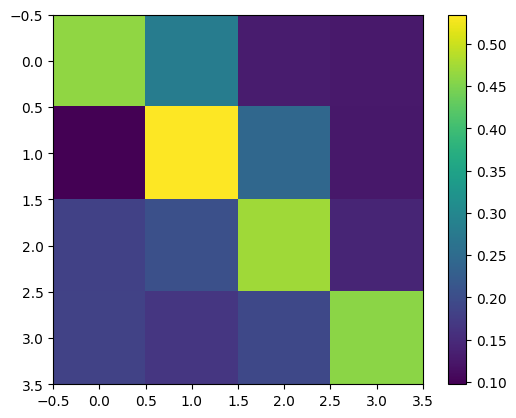

In [33]:
plt.imshow(np.mean(att.detach().numpy(), axis=0), cmap='viridis')
plt.colorbar()
plt.show()